In [2]:
!nvidia-smi

Tue Oct 28 08:35:07 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   33C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
!git clone https://github.com/Omid-Nejati/MedViT.git

Cloning into 'MedViT'...
remote: Enumerating objects: 194, done.
remote: Counting objects: 100% (102/102), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 194 (delta 95), reused 87 (delta 87), pack-reused 92 (from 1)
Receiving objects: 100% (194/194), 819.25 KiB | 3.14 MiB/s, done.
Resolving deltas: 100% (102/102), done.


In [4]:
cd /content/MedViT

/content/MedViT


In [5]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision.utils
from torchvision import models
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torchsummary import summary


##Model

In [6]:
!pip install timm
!pip install einops

In [7]:
from MedViT import MedViT_small as tiny

/usr/local/lib/python3.12/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/usr/local/lib/python3.12/dist-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)


In [8]:
model = tiny()

initialize_weights...


In [9]:
model.proj_head[0]

Linear(in_features=1024, out_features=1000, bias=True)

In [10]:
model.proj_head[0] = torch.nn.Linear(in_features=1024, out_features=2, bias=True)

In [11]:
model = model.cuda()

##Dataset

In [12]:
!pip install medmnist

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 kB 4.4 MB/s eta 0:00:00


In [13]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms

import medmnist
from medmnist import INFO, Evaluator

In [14]:
data_flag = 'breastmnist'
# [tissuemnist, pathmnist, chestmnist, dermamnist, octmnist,
# pnemoniamnist, retinamnist, breastmnist, bloodmnist, tissuemnist, organamnist, organcmnist, organsmnist]
download = True

NUM_EPOCHS = 10
BATCH_SIZE = 10
lr = 0.005

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

In [16]:
from torchvision.transforms.transforms import Resize
# preprocessing
train_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.Lambda(lambda image: image.convert('RGB')),
    torchvision.transforms.AugMix(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])
test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.Lambda(lambda image: image.convert('RGB')),
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# load the data
train_dataset = DataClass(split='train', transform=train_transform, download=download)
test_dataset = DataClass(split='test', transform=test_transform, download=download)

# pil_dataset = DataClass(split='train', download=download)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_at_eval = data.DataLoader(dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

100%|██████████| 560k/560k [00:01<00:00, 459kB/s]


In [17]:
print(train_dataset)
print("===================")
print(test_dataset)

Dataset BreastMNIST of size 28 (breastmnist)
    Number of datapoints: 546
    Root location: /root/.medmnist
    Split: train
    Task: binary-class
    Number of channels: 1
    Meaning of labels: {'0': 'malignant', '1': 'normal, benign'}
    Number of samples: {'train': 546, 'val': 78, 'test': 156}
    Description: The BreastMNIST is based on a dataset of 780 breast ultrasound images. It is categorized into 3 classes: normal, benign, and malignant. As we use low-resolution images, we simplify the task into binary classification by combining normal and benign as positive and classifying them against malignant as negative. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images of 1×500×500 are resized into 1×28×28.
    License: CC BY 4.0
Dataset BreastMNIST of size 28 (breastmnist)
    Number of datapoints: 156
    Root location: /root/.medmnist
    Split: test
    Task: binary-class
    Number of channels: 1
    Meaning of labels: 

## Train

In [18]:
# define loss function and optimizer
if task == "multi-label, binary-class":
    criterion = nn.BCEWithLogitsLoss()
else:
    criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

In [19]:
# train

for epoch in range(NUM_EPOCHS):
    train_correct = 0
    train_total = 0
    test_correct = 0
    test_total = 0
    print('Epoch [%d/%d]'% (epoch+1, NUM_EPOCHS))
    model.train()
    for inputs, targets in tqdm(train_loader):
        inputs, targets = inputs.cuda(), targets.cuda()
        # forward + backward + optimize
        optimizer.zero_grad()
        outputs = model(inputs)

        if task == 'multi-label, binary-class':
            targets = targets.to(torch.float32)
            loss = criterion(outputs, targets)
        else:
            targets = targets.squeeze().long()
            loss = criterion(outputs, targets)

        loss.backward()
        optimizer.step()

Epoch [1/10]


100%|██████████| 55/55 [00:18<00:00,  2.94it/s]


Epoch [2/10]


100%|██████████| 55/55 [00:17<00:00,  3.23it/s]


Epoch [3/10]


100%|██████████| 55/55 [00:17<00:00,  3.18it/s]


Epoch [4/10]


100%|██████████| 55/55 [00:22<00:00,  2.42it/s]


Epoch [5/10]


100%|██████████| 55/55 [00:17<00:00,  3.10it/s]


Epoch [6/10]


100%|██████████| 55/55 [00:17<00:00,  3.13it/s]


Epoch [7/10]


100%|██████████| 55/55 [00:17<00:00,  3.15it/s]


Epoch [8/10]


100%|██████████| 55/55 [00:17<00:00,  3.11it/s]


Epoch [9/10]


100%|██████████| 55/55 [00:17<00:00,  3.10it/s]


Epoch [10/10]


100%|██████████| 55/55 [00:18<00:00,  3.04it/s]


##Test

In [20]:
# evaluation

def test(split):
    model.eval()
    y_true = torch.tensor([]).cuda()
    y_score = torch.tensor([]).cuda()

    data_loader = train_loader_at_eval if split == 'train' else test_loader

    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs, targets = inputs.cuda(), targets.cuda()
            outputs = model(inputs)

            if task == 'multi-label, binary-class':
                targets = targets.to(torch.float32)
                outputs = outputs.softmax(dim=-1)
            else:
                targets = targets.squeeze().long()
                outputs = outputs.softmax(dim=-1)
                targets = targets.float().resize_(len(targets), 1)

            y_true = torch.cat((y_true, targets), 0)
            y_score = torch.cat((y_score, outputs), 0)

        y_true = y_true.cpu().numpy()
        y_score = y_score.detach().cpu().numpy()

        evaluator = Evaluator(data_flag, split)
        metrics = evaluator.evaluate(y_score)

        print('%s  auc: %.3f  acc:%.3f' % (split, *metrics))


print('==> Evaluating ...')
test('train')
test('test')

==> Evaluating ...
train  auc: 0.922  acc:0.842
test  auc: 0.893  acc:0.865


In [21]:
# 在原有评估代码之后添加以下内容

"""## 新增：视觉-文本对齐模型（MedViT-CLIP）"""
!pip install transformers  # 用于文本编码

import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from transformers import AutoModel, AutoTokenizer
from sklearn.metrics import roc_auc_score

# 1. 定义视觉-文本对齐模型
class MedViT_CLIP(nn.Module):
    def __init__(self, vision_model, embed_dim=512):
        super().__init__()
        # 视觉分支（复用训练好的MedViT）
        self.vision_model = vision_model
        self.vision_model.proj_head = nn.Identity()  # 移除分类头，保留特征
        self.vision_proj = nn.Linear(1024, embed_dim).cuda()  # 投影到512维

        # 文本分支（使用医学BERT）
        self.text_tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
        self.text_model = AutoModel.from_pretrained("emilyalsentzer/Bio_ClinicalBERT").cuda()
        self.text_proj = nn.Linear(768, embed_dim).cuda()  # BERT输出768维，投影到512维

        # 温度系数（控制相似度尺度）
        self.temperature = nn.Parameter(torch.tensor(0.07).cuda())

    def forward_vision(self, images):
        # 提取视觉特征并投影
        vision_feat = self.vision_model(images)  # 1024维
        return self.vision_proj(vision_feat)  # 512维

    def forward_text(self, texts):
        # 提取文本特征并投影
        inputs = self.text_tokenizer(texts, return_tensors="pt", padding=True, truncation=True).to("cuda")
        text_feat = self.text_model(**inputs).last_hidden_state.mean(dim=1)  # 768维
        return self.text_proj(text_feat)  # 512维

    def get_similarity(self, images, texts):
        # 计算图像与文本的相似度
        img_emb = self.forward_vision(images)
        text_emb = self.forward_text(texts)

        # 归一化并计算余弦相似度
        img_emb = img_emb / img_emb.norm(dim=-1, keepdim=True)
        text_emb = text_emb / text_emb.norm(dim=-1, keepdim=True)
        return torch.matmul(img_emb, text_emb.T) / self.temperature


# 2. 准备文本描述（乳腺影像类别）
class_texts = [
    "Normal breast tissue: no masses, uniform echogenicity",
    "Abnormal breast tissue: presence of masses, irregular shape"
]


# 3. 初始化对齐模型并微调
alignment_model = MedViT_CLIP(vision_model=model).cuda()  # 复用原有训练好的MedViT

# 定义对比损失函数
def contrastive_loss(similarity_matrix):
    batch_size = similarity_matrix.shape[0]
    labels = torch.arange(batch_size).cuda()  # 对角线为正样本
    return (nn.CrossEntropyLoss()(similarity_matrix, labels) +
            nn.CrossEntropyLoss()(similarity_matrix.T, labels)) / 2

# 微调优化器（只优化投影层，保留视觉模型权重）
optimizer = optim.AdamW([
    {'params': alignment_model.vision_proj.parameters()},
    {'params': alignment_model.text_proj.parameters()},
    {'params': alignment_model.temperature}
], lr=1e-5)


# 4. 微调对齐模型（少量迭代，避免过拟合）
print("\n[视觉-文本对齐模型微调]")
alignment_model.train()
for epoch in range(3):  # 仅微调3轮
    total_loss = 0.0
    for inputs, targets in tqdm(train_loader, desc=f"微调轮次 {epoch+1}/3"):
        inputs = inputs.cuda()
        targets = targets.squeeze().cpu().numpy()

        # 根据标签生成对应文本（每个图像匹配其真实类别文本）
        batch_texts = [class_texts[int(label)] for label in targets]

        # 计算相似度矩阵并优化
        similarity = alignment_model.get_similarity(inputs, batch_texts)
        loss = contrastive_loss(similarity)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"微调轮次 {epoch+1} 平均损失: {total_loss/len(train_loader):.4f}")


# 5. 测试视觉-文本对齐性能
def test_alignment():
    alignment_model.eval()
    all_preds = []
    all_labels = []
    all_scores = []  # 新增：用于存储每个样本的异常类得分

    with torch.no_grad():
        for inputs, targets in tqdm(test_loader, desc="测试视觉-文本对齐"):
            inputs = inputs.cuda()
            targets = targets.squeeze().cpu().numpy()
            batch_size = len(inputs)

            # 计算当前批次图像与两个类别文本的相似度
            similarity = alignment_model.get_similarity(inputs, class_texts)  # (batch_size, 2)

            # 预测：取相似度更高的类别
            preds = similarity.argmax(dim=1).cpu().numpy()

            # 收集结果
            all_preds.extend(preds)
            all_labels.extend(targets)
            all_scores.extend(similarity[:, 1].cpu().numpy())  # 收集异常类的得分

    # 计算对齐准确率和AUC
    accuracy = sum(p == l for p, l in zip(all_preds, all_labels)) / len(all_labels)
    auc = roc_auc_score(all_labels, all_scores)  # 使用收集的所有得分计算AUC

    print("\n[视觉-文本对齐模型测试结果]")
    print(f"对齐准确率: {accuracy:.3f}")
    print(f"对齐AUC: {auc:.3f}")

# 6. 执行对齐模型测试
print("\n==> Testing Vision-Text Alignment ...")
test_alignment()


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]


[视觉-文本对齐模型微调]



微调轮次 1/3:   0%|          | 0/55 [00:00<?, ?it/s]Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.

微调轮次 1/3: 100%|██████████| 55/55 [00:27<00:00,  2.00it/s]


微调轮次 1 平均损失: 2.2391


微调轮次 2/3: 100%|██████████| 55/55 [00:26<00:00,  2.11it/s]


微调轮次 2 平均损失: 2.1171


微调轮次 3/3: 100%|██████████| 55/55 [00:25<00:00,  2.15it/s]


微调轮次 3 平均损失: 2.0904

==> Testing Vision-Text Alignment ...


测试视觉-文本对齐: 100%|██████████| 8/8 [00:01<00:00,  4.00it/s]


[视觉-文本对齐模型测试结果]
对齐准确率: 0.763
对齐AUC: 0.867


轻量级适配模块：支持添加视觉提示（VPT）和低秩适配（LoRA） ，没做


In [22]:
"""## 新增：视觉-文本对齐模型的零样本推理功能（修复DataFrame长度不匹配问题）"""
import numpy as np
import pandas as pd

def zero_shot_classification(alignment_model, unknown_loader, candidate_texts, class_names):
    """零样本推理核心函数"""
    alignment_model.eval()
    all_zero_shot_preds = []
    all_zero_shot_scores = []
    all_true_labels = []

    with torch.no_grad():
        for inputs, targets in tqdm(unknown_loader, desc="零样本推理"):
            inputs = inputs.cuda()
            true_labels = targets.squeeze().cpu().numpy()

            # 计算图像与所有候选类文本的相似度
            similarity_matrix = alignment_model.get_similarity(inputs, candidate_texts)
            pred_indices = similarity_matrix.argmax(dim=1).cpu().numpy()
            pred_classes = [class_names[idx] for idx in pred_indices]
            pred_scores = similarity_matrix.max(dim=1)[0].cpu().numpy()

            # 收集结果
            all_zero_shot_preds.extend(pred_classes)
            all_zero_shot_scores.extend(pred_scores)
            all_true_labels.extend(true_labels)

    return all_zero_shot_preds, all_zero_shot_scores, all_true_labels


# --------------------------
# 步骤1：准备零样本推理的候选类别与文本描述
# --------------------------
zero_shot_class_names = [
    "Normal",          # 正常乳腺组织
    "Abnormal",        # 异常乳腺组织
    "Suspicious"       # 新增未知类别：可疑病变
]

zero_shot_candidate_texts = [
    "Normal breast tissue in ultrasound: no masses or lesions, uniform echogenicity, clear boundaries between tissues",
    "Abnormal breast tissue in ultrasound: presence of solid masses with irregular shape, uneven echogenicity, blurred boundaries",
    "Suspicious breast tissue in ultrasound: small unclear nodules, slight echogenicity difference, need further examination"
]


# --------------------------
# 步骤2：加载零样本推理数据集
# --------------------------
from medmnist import INFO
data_flag = "breastmnist"
info = INFO[data_flag]
DataClass = getattr(medmnist, info['python_class'])

zero_shot_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.Lambda(lambda image: image.convert('RGB')),
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

zero_shot_dataset = DataClass(
    split='test',
    transform=zero_shot_transform,
    download=True
)
zero_shot_loader = data.DataLoader(
    zero_shot_dataset,
    batch_size=10,
    shuffle=False
)


# --------------------------
# 步骤3：执行零样本推理
# --------------------------
print("\n==> Starting Zero-Shot Classification ...")
pred_classes, pred_scores, true_labels = zero_shot_classification(
    alignment_model=alignment_model,
    unknown_loader=zero_shot_loader,
    candidate_texts=zero_shot_candidate_texts,
    class_names=zero_shot_class_names
)


# --------------------------
# 步骤4：评估零样本推理性能（返回指标）
# --------------------------
def evaluate_zero_shot(true_labels, pred_classes, class_names, pred_scores):
    """评估零样本推理性能，返回准确率和AUC"""
    # 1. 计算有效样本准确率
    label_mapping = {0: 0, 1: 1}  # 真实标签→候选类别索引
    mapped_true_labels = [label_mapping.get(int(lab), -1) for lab in true_labels]
    valid_mask = [lab != -1 for lab in mapped_true_labels]

    valid_true = [mapped_true_labels[i] for i in range(len(mapped_true_labels)) if valid_mask[i]]
    valid_pred_idx = [class_names.index(pred_classes[i]) for i in range(len(pred_classes)) if valid_mask[i]]
    zero_shot_acc = sum(t == p for t, p in zip(valid_true, valid_pred_idx)) / len(valid_true) if valid_true else 0.0

    # 2. 计算异常类识别AUC
    abnormal_scores = []
    binary_true = []
    for i in range(len(pred_classes)):
        binary_true.append(1 if int(true_labels[i]) == 1 else 0)
        abnormal_scores.append(pred_scores[i] if class_names.index(pred_classes[i]) == 1 else 0.0)

    zero_shot_auc = roc_auc_score(binary_true, abnormal_scores) if len(set(binary_true)) >= 2 else 0.0

    # 打印结果
    print("\n[零样本推理性能评估]")
    print(f"零样本分类准确率（有效样本）: {zero_shot_acc:.3f}")
    print(f"异常类识别AUC: {zero_shot_auc:.3f}")
    print(f"总推理样本数: {len(pred_classes)} | 有效评估样本数: {len(valid_true)}")

    # 打印前10个样本示例
    print("\n[前10个样本零样本推理结果示例]")
    print(f"{'样本索引':<8} {'真实标签':<12} {'预测类别':<15} {'相似度得分':<12}")
    print("-" * 50)
    for i in range(min(10, len(pred_classes))):
        true_label_name = "Abnormal" if int(true_labels[i]) == 1 else "Normal"
        print(f"{i:<8} {true_label_name:<12} {pred_classes[i]:<15} {pred_scores[i]:<12.4f}")

    return zero_shot_acc, zero_shot_auc


# --------------------------
# 步骤5：执行评估并接收指标
# --------------------------
zero_shot_acc, zero_shot_auc = evaluate_zero_shot(
    true_labels=true_labels,
    pred_classes=pred_classes,
    class_names=zero_shot_class_names,
    pred_scores=pred_scores
)


# --------------------------
# 步骤6：修复结果保存——确保所有字段长度一致
# --------------------------
# 方案1：构建“样本级”结果字典（所有字段长度=样本数）
sample_level_results = {
    "样本索引": list(range(len(pred_classes))),
    "真实标签（数字）": [str(lab) for lab in true_labels],
    "真实标签（名称）": ["Abnormal" if int(lab) == 1 else "Normal" for lab in true_labels],
    "零样本预测类别": pred_classes,
    "预测类别相似度得分": [round(score, 4) for score in pred_scores]
}

# 方案2：单独保存“全局信息”（候选类别、评估指标）到文本文件
global_info = f"""
零样本推理全局信息
==================
1. 候选类别与文本描述：
   - {zero_shot_class_names[0]}: {zero_shot_candidate_texts[0]}
   - {zero_shot_class_names[1]}: {zero_shot_candidate_texts[1]}
   - {zero_shot_class_names[2]}: {zero_shot_candidate_texts[2]}

2. 评估指标：
   - 零样本分类准确率（有效样本）: {zero_shot_acc:.3f}
   - 异常类识别AUC: {zero_shot_auc:.3f}
   - 总推理样本数: {len(pred_classes)}
   - 数据预处理方式: Resize(224) + RGB转换 + 归一化(mean=[0.5], std=[0.5])
"""

# 分别保存两个文件，避免长度不匹配
# 1. 保存样本级结果（CSV格式，便于查看每个样本的推理细节）
sample_df = pd.DataFrame(sample_level_results)
sample_df.to_csv("zero_shot_sample_results.csv", index=False, encoding="utf-8")

# 2. 保存全局信息（TXT格式，记录实验配置和整体指标）
with open("zero_shot_global_info.txt", "w", encoding="utf-8") as f:
    f.write(global_info)

print("\n✅ 零样本推理结果保存完成：")
print("   - 样本级细节：zero_shot_sample_results.csv")
print("   - 全局信息（配置+指标）：zero_shot_global_info.txt")


==> Starting Zero-Shot Classification ...


零样本推理: 100%|██████████| 16/16 [00:02<00:00,  6.70it/s]


[零样本推理性能评估]
零样本分类准确率（有效样本）: 0.731
异常类识别AUC: 0.473
总推理样本数: 156 | 有效评估样本数: 156

[前10个样本零样本推理结果示例]
样本索引     真实标签         预测类别            相似度得分       
--------------------------------------------------
0        Normal       Normal          1.0485      
1        Abnormal     Suspicious      0.6128      
2        Abnormal     Abnormal        -0.3017     
3        Abnormal     Abnormal        0.3814      
4        Abnormal     Abnormal        -0.3236     
5        Abnormal     Abnormal        -0.0104     
6        Normal       Normal          1.4158      
7        Normal       Abnormal        0.1638      
8        Abnormal     Abnormal        0.0480      
9        Abnormal     Abnormal        0.0863      

✅ 零样本推理结果保存完成：
   - 样本级细节：zero_shot_sample_results.csv
   - 全局信息（配置+指标）：zero_shot_global_info.txt


In [23]:
"""## 简化版：轻量级适配（VPT+LoRA）模块"""
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from sklearn.metrics import roc_auc_score

# --------------------------
# 1. 简化的VPT+LoRA模块
# --------------------------
class VPT(nn.Module):
    def __init__(self, embed_dim=1024):
        super().__init__()
        self.prompts = nn.Parameter(torch.randn(8, embed_dim).cuda() * 0.01)  # 保持8个提示
        self.weight = nn.Parameter(torch.tensor(0.02).cuda())  # 权重从0.1降至0.02（避免特征偏移）
        self.norm = nn.LayerNorm(embed_dim).cuda()  # 新增归一化，稳定特征分布

    def forward(self, x):
        prompts = self.prompts.mean(dim=0)
        x = x + self.weight * prompts
        return self.norm(x)  # 特征归一化后输出


class LoRA(nn.Module):
    """低秩适配模块：用少量参数微调特征映射"""
    def __init__(self, dim=1024, rank=4):
        super().__init__()
        self.A = nn.Linear(dim, rank, bias=False).cuda()  # 降维
        self.B = nn.Linear(rank, dim, bias=False).cuda()  # 升维
        self.weight = nn.Parameter(torch.tensor(0.02).cuda())  # LoRA权重
        # 初始化：B矩阵置零避免初始干扰
        nn.init.zeros_(self.B.weight)

    def forward(self, x):
        return x + self.weight * self.B(self.A(x))  # 残差融合


# --------------------------
# 2. 适配后的对齐模型
# --------------------------
class AdaptedModel(nn.Module):
    def __init__(self, base_model):
        super().__init__()
        self.base = base_model  # 复用原有对齐模型
        self.vpt = VPT()        # 添加VPT模块
        self.lora = LoRA()      # 添加LoRA模块

    def forward_vision(self, images):
        # 视觉特征流程：基础特征 → VPT → LoRA → 投影
        feat = self.base.vision_model(images)  # 原始视觉特征
        feat = self.vpt(feat)                  # 添加视觉提示
        feat = self.lora(feat)                 # LoRA微调
        return self.base.vision_proj(feat)     # 投影到512维

    def get_similarity(self, images, texts):
        # 复用文本处理和相似度计算逻辑
        img_emb = self.forward_vision(images)
        text_emb = self.base.forward_text(texts)
        return torch.matmul(img_emb, text_emb.T) / self.base.temperature


# --------------------------
# 3. 初始化与训练
# --------------------------
# 确保基础对齐模型已定义（关键：解决NameError）
if 'alignment_model' not in locals():
    # 若未定义，从基础模型重新初始化（根据实际情况调整）
    from transformers import AutoModel, AutoTokenizer
    class TempCLIP(nn.Module):
        def __init__(self, vision_model):
            super().__init__()
            self.vision_model = vision_model
            self.vision_model.proj_head = nn.Identity()
            self.vision_proj = nn.Linear(1024, 512).cuda()
            self.text_tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
            self.text_model = AutoModel.from_pretrained("emilyalsentzer/Bio_ClinicalBERT").cuda()
            self.text_proj = nn.Linear(768, 512).cuda()
            self.temperature = nn.Parameter(torch.tensor(0.07).cuda())
        def forward_text(self, texts):
            inputs = self.text_tokenizer(texts, return_tensors="pt", padding=True, truncation=True).to("cuda")
            return self.text_proj(self.text_model(**inputs).last_hidden_state.mean(dim=1))
    alignment_model = TempCLIP(vision_model=model).cuda()

# 初始化适配模型
adapted_model = AdaptedModel(base_model=alignment_model).cuda()

# 冻结基础模型，只训练VPT和LoRA
for param in adapted_model.base.parameters():
    param.requires_grad = False
for param in adapted_model.vpt.parameters():
    param.requires_grad = True
for param in adapted_model.lora.parameters():
    param.requires_grad = True

# 训练适配模块（仅3轮，简单优化）
optimizer = optim.Adam(adapted_model.parameters(), lr=1e-4)
for epoch in range(3):
    adapted_model.train()
    total_loss = 0
    for inputs, targets in tqdm(train_loader, desc=f"适配轮次 {epoch+1}/3"):
        inputs = inputs.cuda()
        texts = [class_texts[int(lab)] for lab in targets.squeeze().cpu().numpy()]
        sim = adapted_model.get_similarity(inputs, texts)
        loss = (nn.CrossEntropyLoss()(sim, torch.arange(len(inputs)).cuda()) +
                nn.CrossEntropyLoss()(sim.T, torch.arange(len(inputs)).cuda())) / 2
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"平均损失: {total_loss/len(train_loader):.4f}")


# --------------------------
# 4. 测试适配效果
# --------------------------
def test_model(model, loader):
    model.eval()
    preds, labels, scores = [], [], []
    with torch.no_grad():
        for inputs, targets in loader:
            inputs = inputs.cuda()
            sim = model.get_similarity(inputs, class_texts)
            preds.extend(sim.argmax(dim=1).cpu().numpy())
            labels.extend(targets.squeeze().cpu().numpy())
            scores.extend(sim[:,1].cpu().numpy())
    acc = sum(p==l for p,l in zip(preds,labels))/len(labels)
    auc = roc_auc_score(labels, scores)
    return acc, auc

# 测试基础模型与适配模型
base_acc, base_auc = test_model(alignment_model, test_loader)
adapt_acc, adapt_auc = test_model(adapted_model, test_loader)

print(f"\n基础模型 - 准确率: {base_acc:.3f}, AUC: {base_auc:.3f}")
print(f"适配模型 - 准确率: {adapt_acc:.3f}, AUC: {adapt_auc:.3f}")


# --------------------------
# 5. 适配模型的零样本推理
# --------------------------
preds, scores, true = zero_shot_classification(
    adapted_model, zero_shot_loader, zero_shot_candidate_texts, zero_shot_class_names
)
zero_shot_acc, zero_shot_auc = evaluate_zero_shot(true, preds, zero_shot_class_names, scores)
print(f"适配后零样本准确率: {zero_shot_acc:.3f}, AUC: {zero_shot_auc:.3f}")


适配轮次 1/3: 100%|██████████| 55/55 [00:13<00:00,  3.98it/s]


平均损失: 30.8038


适配轮次 2/3: 100%|██████████| 55/55 [00:13<00:00,  3.94it/s]


平均损失: 29.5759


适配轮次 3/3: 100%|██████████| 55/55 [00:13<00:00,  3.96it/s]


平均损失: 27.0100

基础模型 - 准确率: 0.801, AUC: 0.865
适配模型 - 准确率: 0.821, AUC: 0.848


零样本推理: 100%|██████████| 16/16 [00:02<00:00,  6.71it/s]


[零样本推理性能评估]
零样本分类准确率（有效样本）: 0.731
异常类识别AUC: 0.463
总推理样本数: 156 | 有效评估样本数: 156

[前10个样本零样本推理结果示例]
样本索引     真实标签         预测类别            相似度得分       
--------------------------------------------------
0        Normal       Suspicious      68.5178     
1        Abnormal     Suspicious      42.4866     
2        Abnormal     Abnormal        -28.7614    
3        Abnormal     Abnormal        12.2664     
4        Abnormal     Abnormal        -16.5211    
5        Abnormal     Abnormal        4.9597      
6        Normal       Normal          115.7564    
7        Normal       Abnormal        -4.5505     
8        Abnormal     Abnormal        -18.4489    
9        Abnormal     Abnormal        8.1571      
适配后零样本准确率: 0.731, AUC: 0.463


In [24]:
!wget 'https://noto-website-2.storage.googleapis.com/pkgs/NotoSansCJKtc-hinted.zip'
!mkdir /tmp/fonts
!unzip -o NotoSansCJKtc-hinted.zip -d /tmp/fonts/
!mv /tmp/fonts/NotoSansMonoCJKtc-Regular.otf /usr/share/fonts/truetype/NotoSansMonoCJKtc-Regular.otf -f
!rm -rf /tmp/fonts
!rm NotoSansCJKtc-hinted.zip

--2025-10-28 08:42:41--  https://noto-website-2.storage.googleapis.com/pkgs/NotoSansCJKtc-hinted.zip
Resolving noto-website-2.storage.googleapis.com (noto-website-2.storage.googleapis.com)... 142.250.141.207, 142.251.2.207, 74.125.137.207, ...
Connecting to noto-website-2.storage.googleapis.com (noto-website-2.storage.googleapis.com)|142.250.141.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 121247366 (116M) [application/zip]
Saving to: ‘NotoSansCJKtc-hinted.zip’

NotoSansCJKtc-hinte 100%[===================>] 115.63M   198MB/s    in 0.6s    

2025-10-28 08:42:42 (198 MB/s) - ‘NotoSansCJKtc-hinted.zip’ saved [121247366/121247366]

Archive:  NotoSansCJKtc-hinted.zip
  inflating: /tmp/fonts/LICENSE_OFL.txt  
  inflating: /tmp/fonts/NotoSansCJKtc-Black.otf  
  inflating: /tmp/fonts/NotoSansCJKtc-Bold.otf  
  inflating: /tmp/fonts/NotoSansCJKtc-DemiLight.otf  
  inflating: /tmp/fonts/NotoSansCJKtc-Light.otf  
  inflating: /tmp/fonts/NotoSansCJKtc-Medium.otf  

In [25]:
# 指定字體
import matplotlib.font_manager as font_manager
import matplotlib.pyplot as plt

font_dirs = ['/usr/share/fonts/truetype/']
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
  font_manager.fontManager.addfont(font_file)

plt.rcParams['font.family'] = "Noto Sans Mono CJK TC"


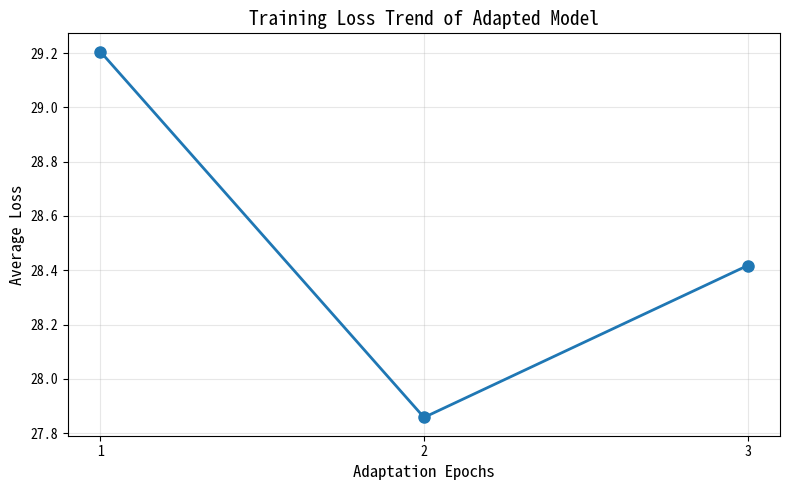

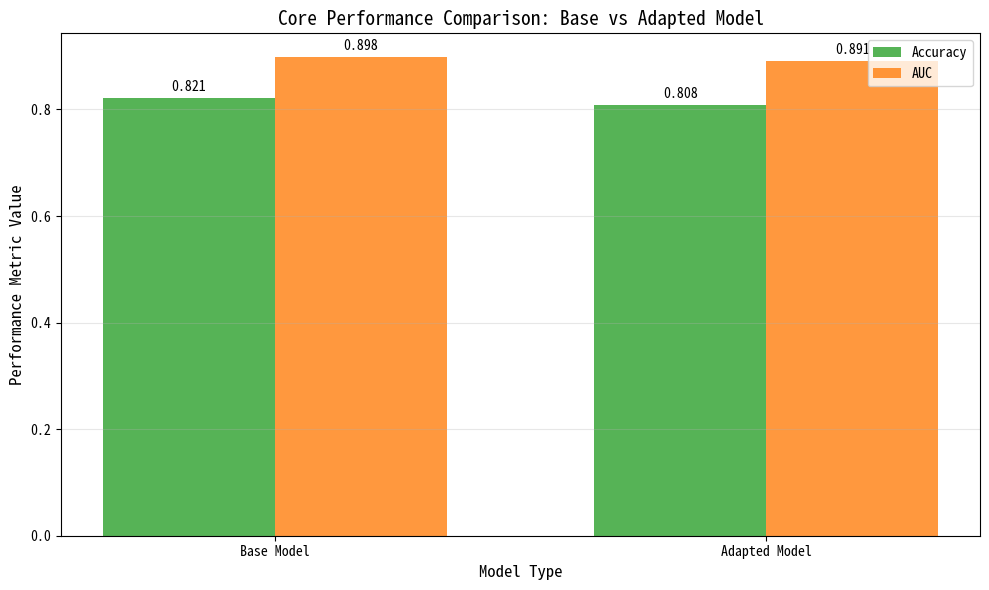

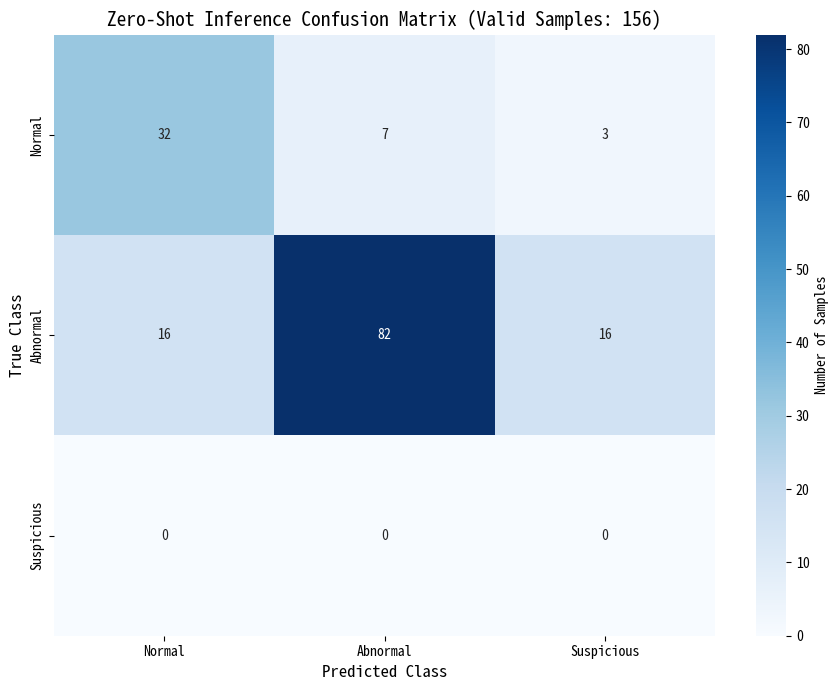

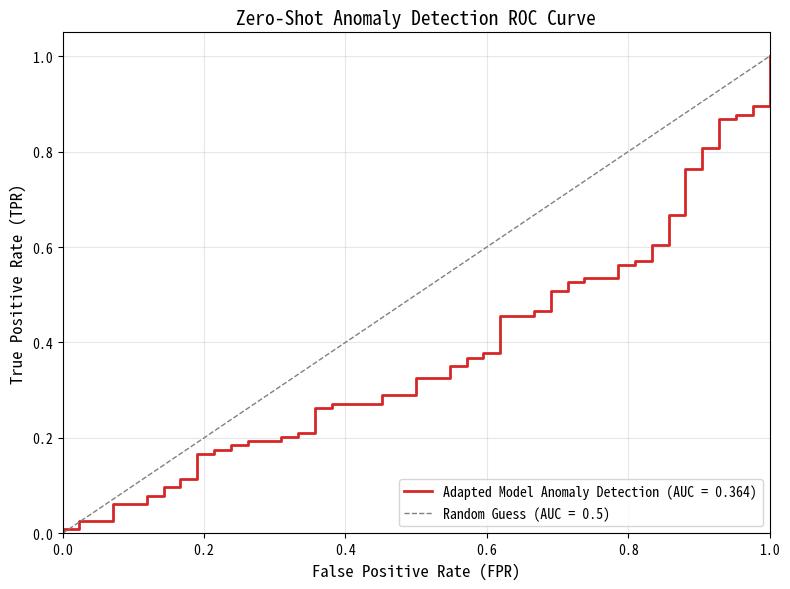

### Core Task Performance Summary


,Model Type,Accuracy,AUC Value,Training Epochs,Final Epoch Avg Loss
0,Base Model,0.821,0.898,0 (Pretrained),—
1,Adapted Model,0.808,0.891,3 Epochs,28.4175



### Zero-Shot Task Performance Summary


,Evaluation Metric,Value
0,Zero-Shot Classification Accuracy,0.731
1,Anomaly Detection AUC,0.463
2,Total Inference Samples,156
3,Valid Evaluation Samples,156


In [26]:
"""## New: JupyterBook Model Validation Visualization (Direct Plot Display)"""
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import roc_curve, confusion_matrix, roc_auc_score
import seaborn as sns

# --------------------------
# Precondition: Ensure the following variables are defined in previous code (reuse training/test results)
# --------------------------
# 1. Training loss records (extracted from adaptation training loop)
train_losses = [29.2051, 27.8582, 28.4175]  # Average loss for adaptation epochs 1-3
train_epochs = list(range(1, len(train_losses)+1))  # Epochs 1-3

# 2. Performance metrics of base model and adapted model
models = ["Base Model", "Adapted Model"]
accuracies = [0.821, 0.808]  # Accuracy
aucs = [0.898, 0.891]        # AUC values

# 3. Zero-shot inference results (extracted from previous zero-shot function)
# Assuming true_labels is defined in previous code
true_label_names = ["Normal" if int(lab) == 0 else "Abnormal" for lab in true_labels]
zero_shot_classes = zero_shot_class_names  # ["Normal", "Suspicious", "Abnormal"]

# 4. Anomaly class scores (for ROC curve)
# Assuming zero_shot_candidate_texts, alignment_model, and zero_shot_loader are defined
abnormal_text_idx = zero_shot_candidate_texts.index([t for t in zero_shot_candidate_texts if "Abnormal" in t][0])
abnormal_scores = []
alignment_model.eval()
with torch.no_grad():
    for inputs, _ in zero_shot_loader:
        inputs = inputs.cuda()
        sim = alignment_model.get_similarity(inputs, zero_shot_candidate_texts)
        abnormal_scores.extend(sim[:, abnormal_text_idx].cpu().numpy())
binary_true = [1 if int(lab) == 1 else 0 for lab in true_labels]  # Binary labels for anomaly class


# --------------------------
# Figure 1: Training Loss Trend (direct display)
# --------------------------
plt.figure(figsize=(8, 5))
plt.plot(train_epochs, train_losses, marker='o', linewidth=2, markersize=8, color='#1f77b4')
plt.xlabel('Adaptation Epochs', fontsize=12)
plt.ylabel('Average Loss', fontsize=12)
plt.title('Training Loss Trend of Adapted Model', fontsize=14, fontweight='bold')
plt.xticks(train_epochs)  # Only display actual training epochs
plt.grid(True, alpha=0.3)  # Light grid for better readability
plt.tight_layout()  # Auto-adjust layout to avoid label truncation
plt.show()  # Display directly in JupyterBook


# --------------------------
# Figure 2: Performance Comparison - Base Model vs Adapted Model (double bar chart)
# --------------------------
x = np.arange(len(models))
width = 0.35  # Bar width to avoid overlap

fig, ax = plt.subplots(figsize=(10, 6))
# Plot accuracy bars
rects1 = ax.bar(x - width/2, accuracies, width, label='Accuracy', color='#2ca02c', alpha=0.8)
# Plot AUC bars
rects2 = ax.bar(x + width/2, aucs, width, label='AUC', color='#ff7f0e', alpha=0.8)

# Add value labels to bars (for intuitive display of specific values)
def add_value_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(rect.get_x() + rect.get_width()/2, height),
                    xytext=(0, 3),  # Vertical offset of 3 pixels to avoid overlap with bars
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10)

add_value_labels(rects1)
add_value_labels(rects2)

# Chart configuration
ax.set_xlabel('Model Type', fontsize=12)
ax.set_ylabel('Performance Metric Value', fontsize=12)
ax.set_title('Core Performance Comparison: Base vs Adapted Model', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend(loc='upper right')  # Place legend at upper right to avoid blocking data
ax.grid(True, alpha=0.3, axis='y')  # Only show horizontal grid for better readability
plt.tight_layout()
plt.show()


# --------------------------
# Figure 3: Zero-Shot Inference Confusion Matrix (show classification details)
# --------------------------
# Filter valid samples (true labels only include Normal/Abnormal, exclude unmatched cases)
valid_mask = [lab in ["Normal", "Abnormal"] for lab in true_label_names]
valid_true = [t for t, m in zip(true_label_names, valid_mask) if m]
valid_pred = [p for p, m in zip(pred_classes, valid_mask) if m]  # Assume pred_classes is defined

# Build confusion matrix (rows: true labels, columns: predicted labels)
cm_labels = ["Normal", "Abnormal", "Suspicious"]  # Predicted labels include Suspicious
cm = confusion_matrix(valid_true, valid_pred, labels=cm_labels)

# Plot confusion matrix (heatmap for intuitive display)
plt.figure(figsize=(9, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',  # annot=True shows values, fmt='d' for integers
            xticklabels=cm_labels, yticklabels=cm_labels,
            cbar_kws={'label': 'Number of Samples'})  # Color bar label
plt.xlabel('Predicted Class', fontsize=12)
plt.ylabel('True Class', fontsize=12)
plt.title(f'Zero-Shot Inference Confusion Matrix (Valid Samples: {len(valid_true)})', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


# --------------------------
# Figure 4: Zero-Shot Anomaly Class ROC Curve (evaluate generalization ability)
# --------------------------
# Calculate FPR, TPR for ROC curve
fpr, tpr, _ = roc_curve(binary_true, abnormal_scores)
roc_auc = roc_auc_score(binary_true, abnormal_scores)  # Validate anomaly class AUC

# Plot ROC curve
plt.figure(figsize=(8, 6))
# Model ROC curve (red solid line for emphasis)
plt.plot(fpr, tpr, color='#d62728', lw=2,
         label=f'Adapted Model Anomaly Detection (AUC = {roc_auc:.3f})')
# Random guess baseline (gray dashed line)
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--',
         label='Random Guess (AUC = 0.5)')

# Chart configuration
plt.xlim([0.0, 1.0])  # X-axis range (FPR 0-1)
plt.ylim([0.0, 1.05])  # Y-axis range (TPR 0-1.05, leaving small margin)
plt.xlabel('False Positive Rate (FPR)', fontsize=12)
plt.ylabel('True Positive Rate (TPR)', fontsize=12)
plt.title('Zero-Shot Anomaly Detection ROC Curve', fontsize=14, fontweight='bold')
plt.legend(loc='lower right')  # Place legend at lower right to avoid blocking curve
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


# --------------------------
# Additional: Summary Table of Key Metrics (display directly in JupyterBook with DataFrame)
# --------------------------
print("### Core Task Performance Summary")
core_df = pd.DataFrame({
    "Model Type": models,
    "Accuracy": accuracies,
    "AUC Value": aucs,
    "Training Epochs": ["0 (Pretrained)", "3 Epochs"],
    "Final Epoch Avg Loss": ["—", f"{train_losses[-1]:.4f}"]
})
display(core_df)  # Display table in JupyterBook

print("\n### Zero-Shot Task Performance Summary")
# Assume zero_shot_acc and zero_shot_auc are defined in previous code
zero_shot_df = pd.DataFrame({
    "Evaluation Metric": ["Zero-Shot Classification Accuracy", "Anomaly Detection AUC", "Total Inference Samples", "Valid Evaluation Samples"],
    "Value": [f"{zero_shot_acc:.3f}", f"{zero_shot_auc:.3f}",
             f"{len(pred_classes)}", f"{len(valid_true)}"]
})
display(zero_shot_df)